In [1]:
# Locations
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_MS_DATA = ROOT + "\\Data\\GNPS_all\\"
PATH_SAVE_MODEL = ROOT + "\\Spec2Vec\\models_trained\\"
PATH_SAVE_DATA = ROOT + "\\Spec2Vec\\data\\"
PATH_SPEC2VEC = ROOT + "\\Spec2Vec\\code\\"

In [2]:
import numpy as np
import sys
sys.path.insert(0, PATH_SPEC2VEC)

import helper_functions as functions
import MS_functions

## Import unique-inchi subset

In [3]:
# Import & filter data from unique inchikey dataset
file_json = PATH_MS_DATA + "filtered_data_uniqueInchikey_minpeak10_loss500_2dec_exp001.json"
file_mgf = ROOT + "\\Data\\GNPS_all\\" + "MS_data_allGNPS_uniqueInchikey14_191101.mgf"

spectra, spectra_dict, MS_documents, MS_documents_intensity, spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0,
                                                           exp_intensity_filter = 0.01,
                                                           peaks_per_mz = 15/200,
                                                           min_peaks = 10,
                                                           max_peaks = None,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [4]:
print("Number of imported spectra:", len(spectra))

Number of imported spectra: 10992


In [5]:
spectra[0].inchi

'"InChI=1S/C24H40O5/c1-13(4-7-21(28)29)16-5-6-17-22-18(12-20(27)24(16,17)3)23(2)9-8-15(25)10-14(23)11-19(22)26/h13-20,22,25-27H,4-12H2,1-3H3,(H,28,29)/t13?,14-,15+,16+,17-,18-,19+,20-,22-,23?,24?/m0/s1"'

## Calculate molecular fingerprints

In [6]:
for spec in spectra:
    spec.get_fingerprint(type="ecfp6")

Molecule found using smiles: C1[C@@H]([C@H](O[C@H]1N2C3=C(C(=O)N=C(N3)N)NC2=O)CO)O
Error while handling inchi: "InChI=1S/C18H15NO5/c20-13-7-5-12(6-8-13)3-1-2-4-17(22)19-16-10-9-14(21)11-15(16)18(23)24/h1-11,20-21H,(H,19,22)(H,23,24)/b3-1,4-2+"
Molecule found using smiles: OC1=CC=C(/C=C/C=C/C(NC2=CC=C(O)C=C2C(O)=O)=O)C=C1
Error while handling inchi: "InChI=1S/C16H17NO3/c18-16(17-9-3-4-10-17)6-2-1-5-13-7-8-14-15(11-13)20-12-19-14/h1-2,5-8,11H,3-4,9-10,12H2/b5-1,6-2+"
Molecule found using smiles: O=C(N1CCCC1)/C=C/C=C/C2=CC=C3OCOC3=C2
Error while handling inchi: "InChI=1S/C11H11Br2N5O/c12-7-4-8(18-9(7)13)10(19)15-3-1-2-6-5-16-11(14)17-6/h1-2,4-5,18H,3H2,(H,15,19)(H3,14,16,17)/b2-1"
Molecule found using smiles: C1=C(NC(=C1Br)Br)C(=O)NCC=CC2=CN=C(N2)N
Error while handling inchi: "InChI=1S/C29H45ClN6O9S/c"
Molecule found using smiles: CC[C@H](C)[C@@H](NC(=O)C(O)Cc1ccc(O)c(Cl)c1)C(=O)N1C2CC(CCC2CC1C(=O)NCCCCNC(=N)N)OS(=O)(=O)O
Error while handling inchi: "InChI=1S/C20H22O8/c21-10-16-17(24)18(2

In [12]:
print('fingerprint_type:', spectra[0].fingerprint_type)
print('fingerprint_bits: \n', spectra[0].fingerprint.bits)

fingerprint_type: ecfp6
fingerprint_bits: 
 [13, 20, 36, 45, 140, 176, 183, 367, 391, 418, 517, 534, 591, 643, 650, 652, 700, 934, 1009, 1043, 1066, 1069, 1078, 1134, 1171, 1173, 1200, 1221, 1256, 1294, 1331, 1348, 1379, 1448, 1484, 1547, 1575, 1628, 1636, 1640, 1733, 1795, 1812, 1862, 1905, 1956, 2035, 2080, 2143, 2321, 2346, 2361, 2487, 2553, 2591, 2613, 2711, 2719, 2803, 2887, 2914, 2970, 2971, 3040, 3172, 3196, 3222, 3277, 3312, 3323, 3332, 3346, 3449, 3463, 3464, 3467, 3527, 3587, 3605, 3634, 3643, 3649, 3715, 3801, 3914, 4091]


In [14]:
exclude_IDs = []
for i, spec in enumerate(spectra):
    if spec.fingerprint is None:
        exclude_IDs.append(i)
        
len(exclude_IDs)

1

## Note: only 1 fingerprints could not been made
This spectra will be ignored for the rest of the analysis.

In [15]:
# Get list of all fingerprints
fingerprints = [spectra[i].fingerprint for i in range(len(spectra)) if i not in exclude_IDs]

In [16]:
len(fingerprints)

10991

In [128]:
import MS_similarity_classical as MS_sim_classic

filename = PATH_SAVE_DATA + 'MS_data_allGNPS_uniqueInchikey14_191101_mol_sim_matrix.npy'
MS_sim_classic.mol_sim_matrix(fingerprints,
                               fingerprints,
                               method = 'jaccard',
                               filename = None)

'C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1([C@H](C[C@H]3[C@H]2[C@@H](C[C@H]4[C@@]3(CC[C@H](C4)O)C)O)O)C'

### Test (novel) modified cosine score functions

In [6]:
import MS_similarity_classical as MS_sim_classic

### Now there is 3 ways to compute the modified cosine scores.
1. Greedy method (mostly taken from Simon)
2. Greedy method + some parts compiled using Numba.
3. More precise Hungarian algorithm + using Numba.

In [14]:
%%time
modcos_sim, modcos_matches = MS_sim_classic.modcos_matrix(spectra[:300], 
                  tol = 0.1, 
                  max_mz = 1000.0, 
                  min_mz = 0, 
                  min_intens = 0,
                  filename = None, #'testing_molent_new.npy',
                  method='greedy', #'hungarian',
                  num_workers = 4,
                  safety_points = None)

print(40 * '-')

Calculate pairwise modified cosine scores by  4 number of workers.
  Calculated MolNet for pair  283 -- 285 . (  100.0  % done).----------------------------------------
Wall time: 10.6 s


In [11]:
%%time
modcos_sim_greedy, modcos_matches_greedy = MS_sim_classic.modcos_matrix(spectra[:300], 
                                      tol = 0.1, 
                                      max_mz = 1000.0, 
                                      min_mz = 0, 
                                      min_intens = 0,
                                      filename = None, #'testing_molent_new.npy',
                                      method='greedy-numba', #'hungarian',
                                      num_workers = 4,
                                      safety_points = None)

print(40 * '-')

Calculate pairwise modified cosine scores by  4 number of workers.
  Calculated MolNet for pair  283 -- 285 . (  100.0  % done).---------------------------------------- (  22.22  % done). 26.67  % done). 125 . (  44.44  % done).85 -- 154 . (  48.89  % done).94 -- 264 . (  53.33  % done). 144 -- 239 . (  73.33  % done).
Wall time: 5.18 s


In [8]:
%%time
modcos_sim, modcos_matches = MS_sim_classic.modcos_matrix(spectra[:300], 
                  tol = 0.1, 
                  max_mz = 1000.0, 
                  min_mz = 0, 
                  min_intens = 0,
                  filename = None, #'testing_molent_new.npy',
                  method='hungarian',
                  num_workers = 4,
                  safety_points = None)

print(40 * '-')

Calculate pairwise modified cosine scores by  4 number of workers.
  Calculated MolNet for pair  283 -- 285 . (  100.0  % done).---------------------------------------- done).
Wall time: 10.7 s


In [9]:
modcos_sim.max()

1.0000000000000044

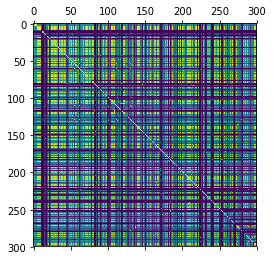

In [10]:
from matplotlib import pyplot as plt
plt.matshow(modcos_sim)

#### Check difference between greedy and hungarian computation:

In [14]:
mat_diff = modcos_sim_greedy - modcos_sim
mat_diff.max(), mat_diff.min()

(4.6629367034256575e-15, -0.04222591692429245)